## Dependencies

In [24]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader,random_split
from torchvision import transforms


import importlib
import dataloader
import config
import model
import train
import utils
import inference


importlib.reload(dataloader)
importlib.reload(config)
importlib.reload(model)
importlib.reload(train)
importlib.reload(utils)

from train import train,validate,inference1
from dataloader import create_dataloaders
from config import Config
from model import ModelV1,initialize_weights
from utils import get_metrics
from inference import Inference

config = Config()

## Prepare Dataset

In [25]:
train_loader, val_loader, hb_mean, hb_std = create_dataloaders(
    data_dir=config.data_dir,
    batch_size=config.batch_size,
    test_split=config.test_split,
)


## Create Model

In [26]:
model_obj = ModelV1(freeze_backbone=True, unfreeze_from_layer='layer4')
if config.load_model:
    model_obj.load_state_dict(torch.load(config.model_load_path))
# else:
#     initialize_weights(model_obj)

## Train

In [27]:
train(model = model_obj,dataloader = train_loader,val_loader = val_loader, config = config)

Training on Device: mps

[Validation] Batch [46/46] - Batch Loss: 0.40145071  ------> Epoch [1/10] Completed. Avg Loss: 0.9926   ------> Validation Loss: 1.1357, R2: 0.0071, MAPE: 118.1310%
[Validation] Batch [46/46] - Batch Loss: 0.49028309  ------> Epoch [2/10] Completed. Avg Loss: 0.9423   ------> Validation Loss: 1.1266, R2: 0.0151, MAPE: 127.4614%
[Validation] Batch [46/46] - Batch Loss: 0.35210563  ------> Epoch [3/10] Completed. Avg Loss: 0.9076   ------> Validation Loss: 1.0624, R2: 0.0712, MAPE: 125.1238%
[Validation] Batch [46/46] - Batch Loss: 0.62195475  ------> Epoch [4/10] Completed. Avg Loss: 0.9220   ------> Validation Loss: 1.1203, R2: 0.0207, MAPE: 146.9440%
[Validation] Batch [46/46] - Batch Loss: 0.80417121  ------> Epoch [5/10] Completed. Avg Loss: 0.8857   ------> Validation Loss: 1.1654, R2: -0.0188, MAPE: 148.7030%
[Validation] Batch [46/46] - Batch Loss: 0.43230948  ------> Epoch [6/10] Completed. Avg Loss: 0.8385   ------> Validation Loss: 1.0205, R2: 0.1079, 

## Validate Model

In [28]:
data2validate = val_loader if val_loader is not None else train_loader
_ = validate(model = model_obj, dataloader = data2validate, config = Config())

[Validation] Batch [46/46] - Batch Loss: 0.6076
[Validation] Completed. Avg Loss: 1.0648

[Validation Metrics]
MSE: 1.0648
RMSE: 1.0319
MAE: 0.7566
R2: 0.0692
MAPE (%): 147.6551


## Inference

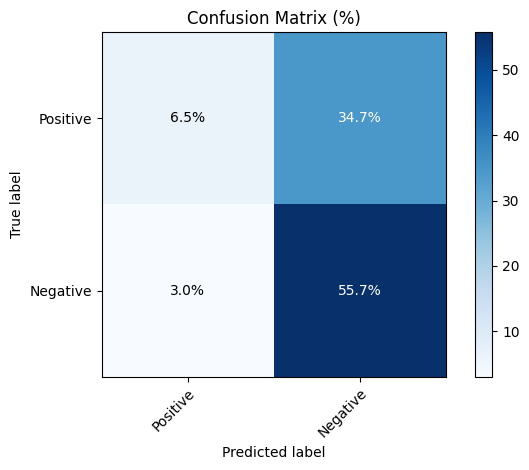

Accuracy: 62.256%
Precision: 0.682
Sensitivity (Recall): 0.158
Specificity: 0.948
F1 Score: 0.256
MAE: 1.540 g/dL


In [29]:
results = []
for i in range(1,462):
    paths = f"/Users/maheshsaravanan/Documents/HemoScan/Dataset/{i:04d}"
    out = inference1(model = model_obj, path = paths,transform = data2validate.dataset.dataset.transform, mean = hb_mean, std = hb_std,Print = False)
    if False:#np.abs(out[0][0]-out[0][1]) > 0.450:
       continue
    else:
        results.append((out))
results = np.array(results).reshape(len(results),2)
get_metrics(results, threshold = 12.0)

## Save Model

In [30]:
if config.save_best_model: torch.save(model_obj.state_dict(), os.path.join(config.model_save_path,'model_weights_2505v1.pth'))

## Predict

In [34]:
infer = Inference()

Model and its weight loaded and pushed to device:mps


In [35]:
path_pf = '/Users/maheshsaravanan/Documents/HemoScan/Dataset/Ideal/PF.jpg'
path_pb = '/Users/maheshsaravanan/Documents/HemoScan/Dataset/Ideal/PB.jpg'

img_pf = Image.open(path_pf).convert("RGB")
img_pb = Image.open(path_pb).convert("RGB")


In [36]:
infer.predict(img_pf,img_pb)

12.74